# Decoding and Analysis of Basic-Conditionals (Oberauer, 2006)

Read in Data

In [4]:
from savReaderWriter import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set(style='ticks')
sns.despine(left=True)


with SavReader('multinomial.daten.gefiltert.sav') as reader:
    header = reader.header
    data = []
    data += [[binary.decode('utf-8') for binary in header]]
    for line in reader:
        data += [line]

    raw = pd.DataFrame(data[1:],columns=data[0])
df = raw.astype(str)
df = df.drop(['alter', 'sex', 'bildung', 'logik', 'Sprache'], axis=1)
raw = df.apply(pd.to_numeric).astype(int)
print(len(raw))

343


In [6]:
# Working copy
df = raw.copy()

#
# Decoding
#

# First, convert from the ideosyncratic oberauer format "2=False, 1=True" 
# to the standard format "0=False, 1=True"
a = ['antw11', 'antw12', 'antw13', 'antw14', 'antw21', 'antw22', 'antw23', 'antw24']
df[a] = df[a].apply(lambda x: x%2)

#
# Data aquisition was done in randomized order.
# To revert this, we reproduce the encoding found in Oberauers SPSS script.
#

# The Modi are encoded with numbers:
mod = {1: 'mp', 2: 'mt', 3: 'ac', 4: 'da'}

# Create empty columns
for i in range(1, 5):
    df[mod[i] + '1'] = np.nan
for i in range(1, 5):
    df[mod[i] + '2'] = np.nan

# Working copy
data = df.copy()

# Itereate over participants, i.e. rows
for row_index in range(len(data)):
    # num is the answer type
    for num in range(1, 5):
        # mod_i is the modus index, e.g. 1 for MP
        for mod_i in range(1, 5):
            if data.loc[row_index]['aussage1'] == 1:
                if data.loc[row_index]['urteil1' + str(num)] == mod_i:
                    data.loc[row_index, mod[mod_i] + '1'] = data.loc[row_index, 'antw1' + str(num)]
                if data.loc[row_index]['urteil2' + str(num)] == mod_i:
                    data.loc[row_index, mod[mod_i] + '2'] = data.loc[row_index, 'antw2' + str(num)]        
            elif data.loc[row_index]['aussage1'] == 2:
                if data.loc[row_index]['urteil2' + str(num)] == mod_i:
                    data.loc[row_index, mod[mod_i] + '2'] = data.loc[row_index, 'antw2' + str(num)]
                if data.loc[row_index]['urteil1' + str(num)] == mod_i:
                    data.loc[row_index, mod[mod_i] + '1'] = data.loc[row_index, 'antw1' + str(num)]
                    
# Use participant number as indices                    
data = data.set_index('VpNr')

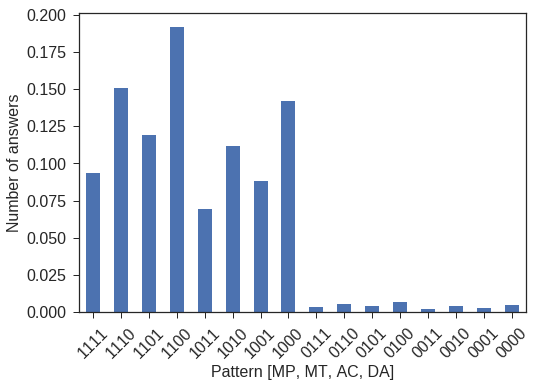

In [45]:
df = data.drop(data.columns[0:-8], axis=1) # The columns -4 to -8 are the conditional 1
agg = df.sum()
agg['mp1'] += agg['mp2']
agg['mt1'] += agg['mt2']
agg['ac1'] += agg['ac2']
agg['da1'] += agg['da2']

agg = agg.drop(['mp2', 'mt2', 'ac2', 'da2'])
agg /= len(raw) * 2
agg.index = ['mp', 'mt', 'ac', 'da']

p = pd.Series()
for mp in (0, 1):
    for mt in (0, 1):
        for ac in (0, 1):
            for da in (0, 1):
                pattern = str(mp) + str(mt) + str(ac) + str(da)
                p.loc[pattern] = agg.mp ** mp * (1 - agg.mp) ** (abs(1 - mp))
                p.loc[pattern] *= agg.mt ** mt * (1 - agg.mt) ** (abs(1 - mt))
                p.loc[pattern] *= agg.ac ** ac * (1 - agg.ac) ** (abs(1 - ac))
                p.loc[pattern] *= agg.da ** da * (1 - agg.da) ** (abs(1 - da))
independent = p.sort_index(ascending=False)                
fontsize = 16
independent.plot(kind='bar', rot=45, fontsize=fontsize)
plt.xlabel('Pattern [MP, MT, AC, DA]', fontsize=fontsize)
plt.ylabel('Number of answers', fontsize=fontsize)
plt.show()

,Card-Number,Triangle-Square
pattern,,
1111,82,88.0
1110,17,16.0
1101,14,13.0
1100,78,73.0
1011,6,13.0
1010,41,30.0
1001,15,20.0
1000,76,81.0
0110,2,1.0


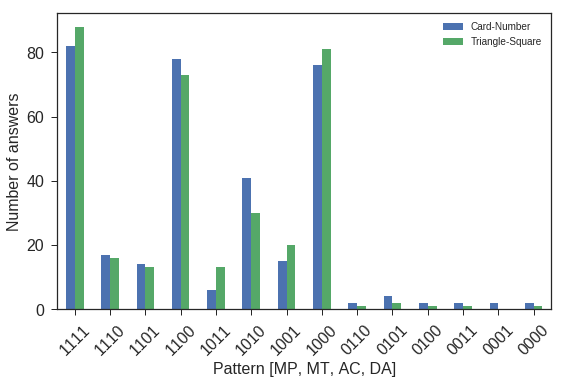

In [10]:
cnt = pd.DataFrame(columns=['Card-Number', "Triangle-Square"])

# Conditional 1
df = data.copy()
df = df.drop(df.columns[0:-8], axis=1) # The columns -4 to -8 are the conditional 1
df = df.drop(df.columns[-4:], axis=1)  # delete everything else


# df = df[['mp2', 'da2', 'ac2', 'mt2']]  # Oberauer ordering
df['pattern'] = df.apply(lambda x: ''.join([str(int(y)) for y in x]), axis=1)
cnt['Card-Number'] = df.groupby(by='pattern').agg('count')[df.columns[0]]

# Conditional 2
df = data.copy()
df = df.drop(df.columns[0:-4], axis=1)
# df = df[['mp1', 'da1', 'ac1', 'mt1']]  # Oberauer ordering
df['pattern'] = df.apply(lambda x: ''.join([str(int(y)) for y in x]), axis=1)
cnt["Triangle-Square"] = df.groupby(by='pattern').agg('count')[df.columns[0]]

# Sort
cnt = cnt.sort_index(ascending=False)
display(cnt)

# Plot
fontsize = 16
cnt.plot(kind='bar', rot=45, fontsize=fontsize)
plt.xlabel('Pattern [MP, MT, AC, DA]', fontsize=fontsize)
plt.ylabel('Number of answers', fontsize=fontsize)

plt.tight_layout()
plt.savefig('16_patterns.pdf', format='pdf')
plt.savefig('../../pics/16_patterns.pdf', format='pdf')

# rel = cnt.copy() / cnt.sum()
# rel.plot(kind='bar')
plt.show()

,Card-Number,Triangle-Square,Independent
pattern,,,
1111,0.239067,0.256560,0.093686
1110,0.049563,0.046647,0.150682
1101,0.040816,0.037901,0.119124
1100,0.227405,0.212828,0.191595
1011,0.017493,0.037901,0.069432
1010,0.119534,0.087464,0.111673
1001,0.043732,0.058309,0.088285
1000,0.221574,0.236152,0.141994
0110,0.005831,0.002915,0.005227


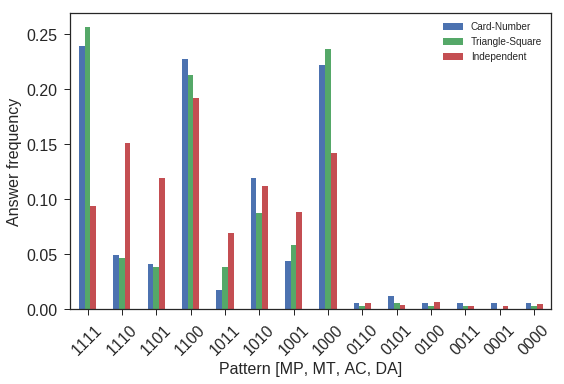

In [48]:
# Paste
patt_ind = pd.DataFrame()
patt_ind['Card-Number Pattern'] = cnt['Card-Number'].copy() / len(raw)
patt_ind['Triangle-Square Pattern'] = cnt['Triangle-Square'].copy() / len(raw)
patt_ind['Independent'] = independent
display(patt_ind)

# Plot
fontsize = 16
patt_ind.plot(kind='bar', rot=45, fontsize=fontsize)
plt.xlabel('Pattern [MP, MT, AC, DA]', fontsize=fontsize)
plt.ylabel('Answer frequency', fontsize=fontsize)

plt.tight_layout()
plt.savefig('16_patterns.pdf', format='pdf')
plt.savefig('../../pics/16_patterns.pdf', format='pdf')

# rel = cnt.copy() / cnt.sum()
# rel.plot(kind='bar')
plt.show()

pattern
2222    60
2221    13
2220     2
2212     5
2211     5
2210     7
2202     2
2201     9
2200    49
2122     5
2121    10
2120     3
2112     4
2111    12
2110     7
2102     2
2101     5
2100    20
2022     1
2021     2
2020    15
2012     3
2011     6
2010    13
2002     5
2001     8
2000    51
1222     1
1211     1
1202     1
1121     1
1112     1
1111     4
1110     1
1101     1
1100     1
1021     1
1010     1
1002     1
0220     1
0210     1
0202     1
0111     1
Name: mp, dtype: int64

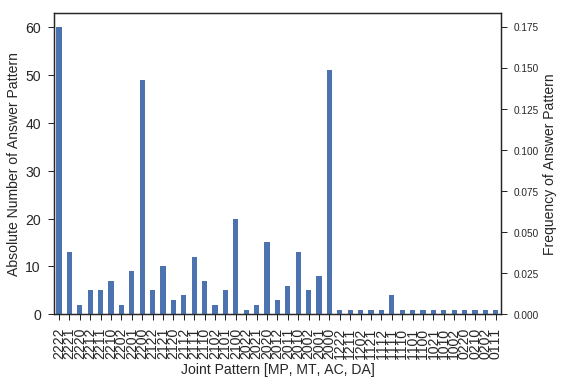

In [11]:
# Generate up to 32 patterns for the combined data of both conditionals
df = data.copy()
# Add answers for each participant
for i in range(1, 5):
    df[mod[i]] = df[mod[i] + '1'] + df[mod[i] + '2']
# Only keep the added answers    
df = df.drop(df.columns[:-4], axis=1)
# Pool&count per pattern
df['pattern'] = df.apply(lambda x: ''.join([str(int(y)) for y in x]), axis=1)
cnt_both = df.groupby(by='pattern').agg('count')[df.columns[0]]
cnt_both = cnt_both.sort_index(ascending=False)

# Save to .csv
cnt_both.to_frame().transpose().to_csv(r'joint_card_triangle.csv', 
                                       sep=',', mode='w')
df = pd.read_csv(r'joint_card_triangle.csv')
df = df.drop(df.columns[0], axis=1)

# Remove irrelevant patterns of frequency 1
#cnt_both = cnt_both[cnt_both > 1]

# Plot
fontsize=14
ax1 = cnt_both.plot(kind='bar', rot=90, fontsize=fontsize)
ax1.set_ylabel('Absolute Number of Answer Pattern', fontsize=fontsize)

rel = cnt_both.copy() / cnt_both.sum()
ax2 = rel.plot(kind='bar', rot=90, fontsize=fontsize, secondary_y=True)
ax2.set_ylabel('Frequency of Answer Pattern', fontsize=fontsize)

ax1.set_xlabel('Joint Pattern [MP, MT, AC, DA]', fontsize=fontsize)

plt.tight_layout()
plt.savefig('81_patterns.pdf', format='pdf')
plt.savefig('../../pics/81_patterns.pdf', format='pdf')

plt.show()